In [1]:
import xarray as xr
import numpy as np
import sys

Read in the POP grid 

In [3]:
popgridfile = "./gx1v7_kmt.nc"
popgrid = xr.open_dataset(popgridfile)
olon = popgrid['TLONG'] ; olat = popgrid['TLAT'] # ocean longitudes and latitudes
region_mask = popgrid['REGION_MASK'] # this is set to 2 in the Pacific.
nlon = popgrid.nlon.size ; nlat=popgrid.nlat.size

In [3]:
def roll_lon2(df):
    df.coords['GRID_X_T'] = (df.coords['GRID_X_T'] + 360) % 360# - 180
    df = df.sortby(df.GRID_X_T)
    return df

In [4]:
mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_25N_25S_5deg_damping_trop_pacific.nc", decode_times=False)

In [5]:
mask = mask.restore_mask

In [6]:
mask0 = (mask*0)

In [7]:
mask01 = roll_lon2(mask0)

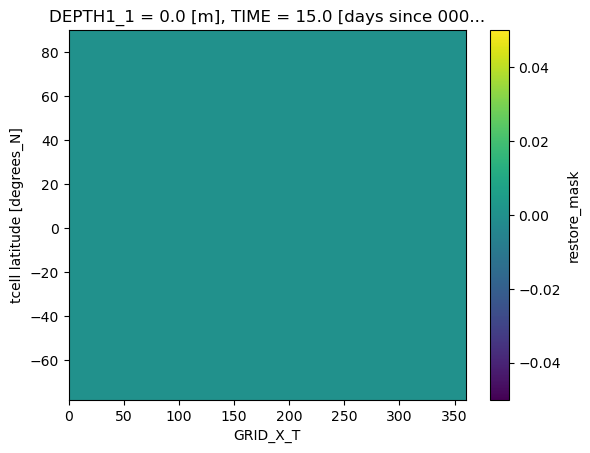

In [8]:
mask01[0,0].plot()

In [10]:
olon = mask01['GRID_X_T'] ; olat = mask01['GRID_Y_T'] # ocean longitudes and latitudes
nlon = mask01.GRID_X_T.size ; nlat=mask01.GRID_Y_T.size

In [11]:
olon

<xarray.DataArray 'GRID_X_T' (GRID_X_T: 360)>
array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

Set up paroll_lon2ters for wedge mask

In [2]:
lonmin_epac=180. # minimum longitude of east pacific rectangle
latedge_epac = 15. # edge latitude of full nudging
latbuffer_epac = 20. # latitude at the edge of the buffer
dbuffer = latbuffer_epac - latedge_epac # length of buffer in degrees
mbuffer = 1./dbuffer # buffer gradient
wedge_w = 135. # western extent of west pacific wedge
mwedge = (latedge_epac - 0.)/(lonmin_epac - wedge_w) # gradient of wedge line
mwedge_perp = -1./mwedge
minlontip = wedge_w - 5.

Stack arrays so we can work on a single dimension

In [45]:
# find elements that are in the pacific (region_mask = 2)
ipac = np.where(region_mask_stacked == 2)[0]

# generate the wedge mask using only pacific grid points
mask = np.zeros([region_mask_stacked.size])
for i in ipac:
    lonval = olon_stacked[i] ; latval = olat_stacked[i]

    # full nudging in the east Pacific
    if ((lonval > lonmin_epac) and (np.abs(latval) < latedge_epac)):
        mask[i] = 1.
        
    # east Pacific taper
    if ( (lonval > lonmin_epac) and (np.abs(latval) >= latedge_epac) and 
        (np.abs(latval) <= latbuffer_epac)):
        mask[i] = mbuffer*(latbuffer_epac - np.abs(latval))
        
    # west Pacific wedge
    if ( (lonval > wedge_w) and (lonval <= lonmin_epac)):
        ylim = mwedge*(lonval - wedge_w) # latitude limit of wedge at lonval
        if (np.abs(latval) <= ylim):
            mask[i] = 1
            
    # west Pacific buffer
    if ( (lonval > wedge_w) and (lonval <= lonmin_epac)):
        ylim = mwedge*(lonval - wedge_w) # latitudinal limit of wedge at lon
        if ( (np.abs(latval) > ylim) and (np.abs(latval) < 35)):
            # find the intercept of the line from the grid point to the full taper which intercepts perpendicularly with the wedge
            # wedge line y = mwedge(x - wedge_w)
            # perpendicular line y = mwedge_perp*(x - lonval) + latval
            xintercept = (mwedge*wedge_w - mwedge_perp*lonval + np.abs(latval))/(mwedge - mwedge_perp)
            yintercept = mwedge*(xintercept - wedge_w)
            
            # find the distance in degrees from the wedge
            distance = np.sqrt( (lonval - xintercept)**2 + (np.abs(latval)-yintercept)**2.)
            mask[i] = 1. - (distance/dbuffer)
            
            #print(i,' ',mask[i])
            
            if (mask[i] < 0):
                mask[i] = 0
                
    # wedge tip buffer
    if ( (lonval >= minlontip) and (lonval < wedge_w)):
        if (np.abs(latval) < (dbuffer +1)):
            distance = np.sqrt( (lonval - wedge_w)**2. + (np.abs(latval)-0)**2.)
            # only fill in the mask if it hasn't already been set in the west pacific buffer#                    
            if (mask[i] == 0):
                mask[i] = 1. - (distance/dbuffer)
                        
            if (mask[i] < 0):
                mask[i] = 0
                


Set land regions to -1

In [46]:
mask = np.where(region_mask_stacked == 0, -1, mask)

In [ ]:
Reshape mask array 

In [52]:
mask = mask.reshape(nlat,nlon)
mask = xr.DataArray(mask, name="SHF_MASK", dims=(["nlat","nlon"])) 
mask.to_netcdf("MASK_gx1v7_PACEMAKER_WEDGE.nc")